In [1]:
import pytorch_lightning as pl
from  data.data_loader import MyDataModule
from training.PL_train import Main_Loop
import torch.optim as optim
import torchio as tio
import torch
import matplotlib.pyplot as plt
from data.validation import utils
from data.brats_nii_data_utils import nni_utils
import numpy as np

In [2]:
size = (48, 64, 48)
model = "Pixel"
criterion = "Tversky"
type_list = ["t1"]
prepare = False
epochs = 100

# BRATS Dataset
data_dir = "/home/ludauter/Documents/brats_example/data/train"

# Pre processings location
out_dir = "/home/ludauter/tumor-segmentation/libs/data/examples"


# Data TRansforms
train_transformer = tio.Compose([
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
])

val_transformer = tio.Compose([
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
])


# Dataloading
data_module = MyDataModule(
    data_dir = data_dir,
    out_dir = out_dir,
    train_transformer=train_transformer,
    val_transformer = val_transformer,
    prepare=prepare,
    size = size,
    type_list = type_list,
    sample_list= type_list
)

In [3]:
model_args = {
            }

In [4]:

trainer = pl.Trainer(gpus=1,max_epochs = epochs)
main = Main_Loop(
    model = model,
    loss= criterion,
    type_list = type_list,
    scheduler = optim.lr_scheduler.ExponentialLR,
    scheduler_args = {"gamma":.97},
    model_args = model_args,
    loss_args={"weight":torch.from_numpy(np.array([.01,2,2,2,2])).float().cuda()   }
)
trainer.fit(main, data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | PixelModel       | 160 M 
1 | loss  | FocalTverskyLoss | 0     
-------------------------------------------
160 M     Trainable params
0         Non-trainable params
160 M     Total params
641.881   Total estimated model params size (MB)


/home/ludauter/tumor-segmentation/libs/data/examples


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
main.load_from_checkpoint("/home/ludauter/tumor-segmentation/libs/lightning_logs/version_4/checkpoints/epoch=99-step=12500.ckpt")

In [ ]:
data_module.valid_dataset[0]

Subject(Keys: ('t1', 'seg', 'id'); images: 2)

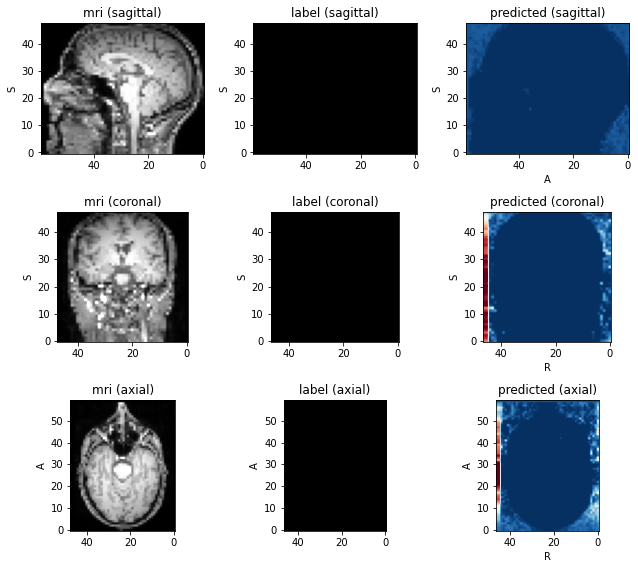

In [ ]:
index = 1

preprocessing_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad(size),
])

dataset = tio.datasets.ixi.IXI(root = "/home/ludauter/Documents/IXI",download=True,modalities  = ["T1"],transform=preprocessing_transform)
FIRST = 0
FOREGROUND = 1

with torch.no_grad():
    pred = main.model(dataset[index]["T1"]["data"].float()).softmax(dim=1)[:, FOREGROUND:].cpu()
    targets = torch.zeros_like(pred)


subject = tio.Subject(
    mri=tio.ScalarImage(tensor=dataset[index]["T1"][tio.DATA] ),
    label=tio.LabelMap(tensor=targets),
    predicted=tio.ScalarImage(tensor=pred ),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

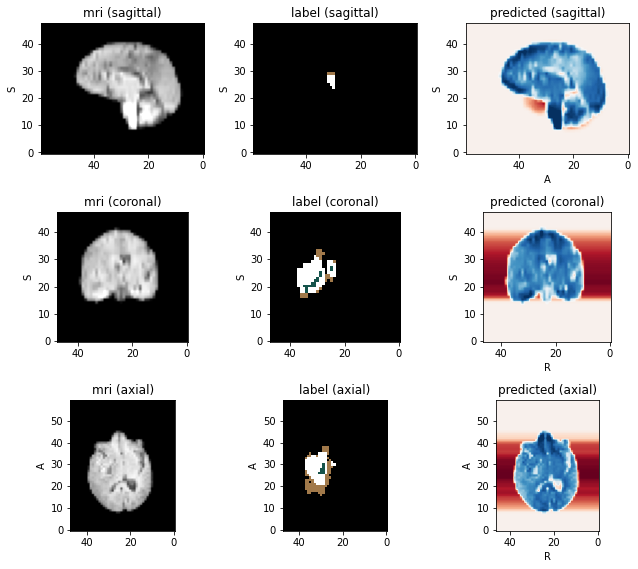

In [ ]:
index = 1

preprocessing_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad(size),
])

FIRST = 0
FOREGROUND = 1

with torch.no_grad():
    pred = main.model(data_module.valid_dataset[index]["t1"]["data"].float()).softmax(dim=1)[:, FOREGROUND:].cpu()
    targets = data_module.valid_dataset[index]["seg"]["data"]

subject = tio.Subject(
    mri=tio.ScalarImage(tensor=data_module.valid_dataset[index]["t1"][tio.DATA] ),
    label=tio.LabelMap(tensor=targets),
    predicted=tio.ScalarImage(tensor=pred ),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

In [ ]:
import torch.nn.functional as F
from layers.pixelshuffle import PixelShuffle
import torch.nn as nn
class Residual(torch.nn.Module):

    def __init__(self,in_channels):
        super().__init__()
        self.down_sample = None
        self.up_sample  = None

        self.up_sample = PixelShuffle(2)

        n = in_channels//2**3
  
        self.f = nn.Sequential(
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n,n,1,1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n,n,3,1,1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n,n,1,1),            
        )

        self.final = nn.Sequential(
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

    def forward(self,X):
        x = self.up_sample(X)

        res = x

        x = self.f(x)

        x = x+res

        return self.final(x)

class Backbone(nn.Module):

    def __init__(self):
        super().__init__()
        self.pre = nn.Sequential(
            nn.Conv3d(1,64,kernel_size=7,stride=2,padding=3,bias=False),
            nn.BatchNorm3d(64),
            nn.GELU(),
            nn.MaxPool3d(kernel_size=3,stride=2,padding=1)
        )

        self.layer1 = ResLayer(64,128,3)
        self.layer2 = ResLayer(128,256,4,stride = 2)
        self.layer3 = ResLayer(256,512,4,stride = 2)
        self.layer4 = ResLayer(512,1024,4,stride = 2)

    def forward(self,X):

        l0 = self.pre(X)

        l1 = self.layer1(l0)

        l2 = self.layer2(l1)

        l3 = self.layer3(l2)

        l4 = self.layer4(l3) 

        return l4


class ResBlock(nn.Module):
    def __init__(self, in_channels,out_channels,stride=1,downsample = False):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv3d(in_channels,out_channels,kernel_size = 3,stride= stride,padding=1,bias=False),
            nn.BatchNorm3d(out_channels),
            nn.GELU(),
            nn.Conv3d(out_channels,out_channels,kernel_size = 1,stride= 1,padding=0,bias=False),
            nn.BatchNorm3d(out_channels)
        )
        self.downsample = None
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels,out_channels,kernel_size=1,stride =stride,bias= False),
                nn.BatchNorm3d(out_channels)
                )

    def forward(self,X):

        x = self.f(X)

        res = X
        if self.downsample is not None:
            res = self.downsample(res)

        x = x+res

        return F.gelu(x)

class ResLayer(nn.Module):
    def __init__(self,in_channels,out_channels,n_blocks,stride =1):
        super().__init__()
        self.f = self.make_layer(in_channels,out_channels,n_blocks,stride)
    def make_layer(self,in_channels,out_channels,n_blocks,stride):
        layers = []
        layers.append(ResBlock(in_channels,out_channels,stride=stride,downsample=True))
        
        for i in range(1,n_blocks):

            layers.append(ResBlock(out_channels,out_channels))

        return nn.Sequential(*layers)

    def forward(self,X):
        x = self.f(X)
        return x


class PixelModel(nn.Module):
    def __init__(self,n_classes,shape = (48,64,48)):
        super().__init__()
        self.f = nn.Sequential(
            Backbone(),
            Residual(1024),
            ResLayer(128,512,3,stride = 1),
            Residual(512),
            ResLayer(64,256,3,stride = 1),
            Residual(256),
            ResLayer(32,128,3,stride = 1),
            Residual(128),
            ResLayer(16,64,3,stride = 1),
            Residual(64),
            ResLayer(8,32,3,stride = 1),
            nn.Conv3d(32,n_classes,3,1,1)
        )
    def forward(self,X):
        x = self.f(X)
        x  = nn.functional.interpolate(x,size = (48,64,48))
        return x

In [ ]:
model = PixelModel(n_classes = 5)

In [ ]:
X = torch.randn((4,1,48,64,48))
x = model(X)
x.shape

torch.Size([4, 5, 48, 64, 48])